In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import collections


from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from colour import Color

In [ ]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')

%matplotlib inline
linewidth = 3

## Get data from comet.ml

In [2]:
comet_api = API(api_key='YOUR KEY')
comet_api.get()

['ketrint']

In [3]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']


In [4]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [20]:
def plot_mean(idx, mean, label="", i=0):
    idx = np.array(idx)
    mean = np.array(mean)
    plt.scatter(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5, s = 400)

In [5]:
experiments_name = ['clustering-parameters-choice-final']

In [6]:
experiments = comet_api.get(workspace='ketrint', project_name=experiments_names[i])

In [10]:
from collections import defaultdict

GS = defaultdict(list)
E = defaultdict(list)
for exp in experiments:
    good_showers = new_to_old_metric(exp, "Good showers")
    e = new_to_old_metric(exp, "Energy resolution")
    #print(good_showers)
    #print(e)
    if len(good_showers):
        threshold = float(exp.get_command()[-9])
        GS[threshold].append(good_showers[0])
        E[threshold].append(e[0])

In [14]:
GS_od = collections.OrderedDict(sorted(GS.items()))
E_od = collections.OrderedDict(sorted(E.items()))

In [18]:
GS_mean = []
E_mean = []
for key in GS_od.keys():
    GS_mean.append(np.mean(GS_od[key]))
    E_mean.append(np.mean(E_od[key]))

In [19]:
keys = list(GS_od.keys())

## Energy resolution - Recovered showers trade-off depending on the threshold

In [23]:
colors = ['darkslateblue','SteelBlue', 'teal', 'gold', 'DarkOrange', 'firebrick']

### Scatter plot

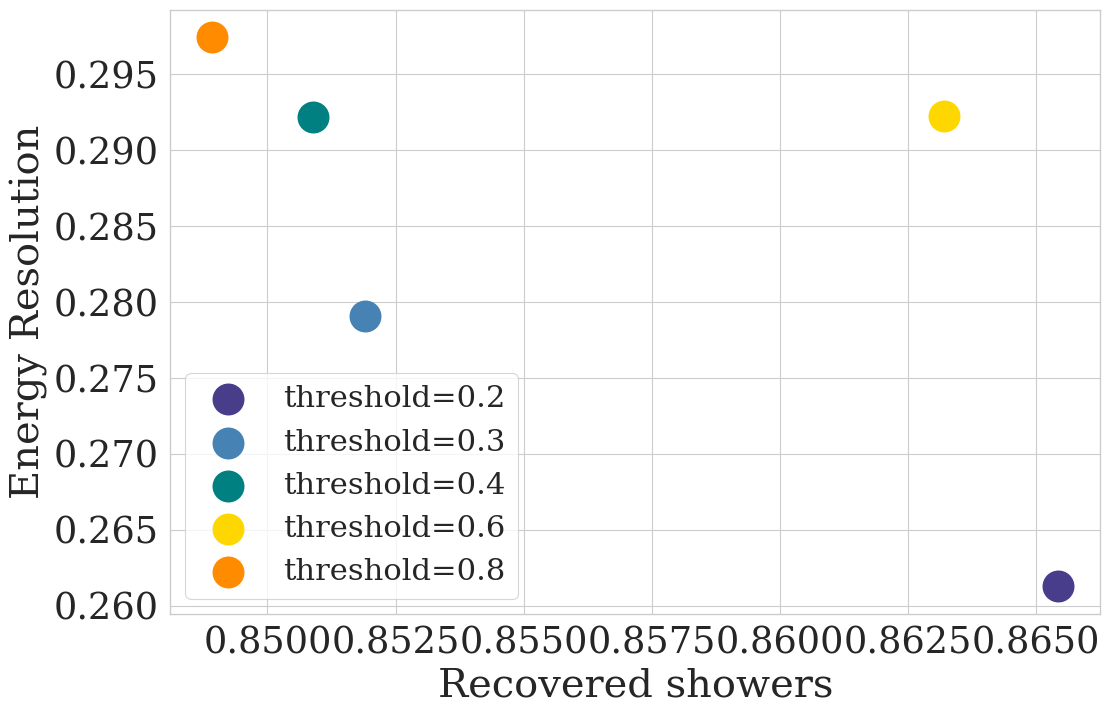

In [27]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
for i, key in enumerate(keys[:]):
    plot_mean(GS_mean[i], E_mean[i], label="threshold={}".format(key), i=i)
    

#plt.plot(GS_mean, E_mean)
plt.ylabel("Energy Resolution")
plt.xlabel("Recovered showers")
# plt.ylim
plt.legend(loc='best', fontsize=22)
plt.savefig("E_RS.pdf", bbox_inches='tight')
plt.show()

### Box plot

In [28]:
def boxplot_2d(x,y, color, ax, label, whis=1.5):
    xlimits = [np.percentile(x, q) for q in (25, 50, 75)]
    ylimits = [np.percentile(y, q) for q in (25, 50, 75)]
    
    x_std = np.std(x)
    y_std = np.std(y)

    ##the box
    box = Rectangle(
        (xlimits[1]-x_std/2,ylimits[1]-y_std/2),
        (x_std),
        (y_std),
        label=label,
        color=color,
        alpha = 0.7,
        ec = 'k',
        zorder=0
    )
    ax.add_patch(box)
    
    ##the x median
    vline = Line2D(
        [xlimits[1],xlimits[1]],[ylimits[1]-y_std/2,ylimits[1]+y_std/2],
        color='k',
        zorder=1
    )
    ax.add_line(vline)

    ##the y median
    hline = Line2D(
        [xlimits[1]-x_std/2,xlimits[1]+x_std/2],[ylimits[1],ylimits[1]],
        color='k',
        zorder=1
    )
    ax.add_line(hline)

    ##the central point
    ax.plot([xlimits[1]],[ylimits[1]], color='k', marker='o')

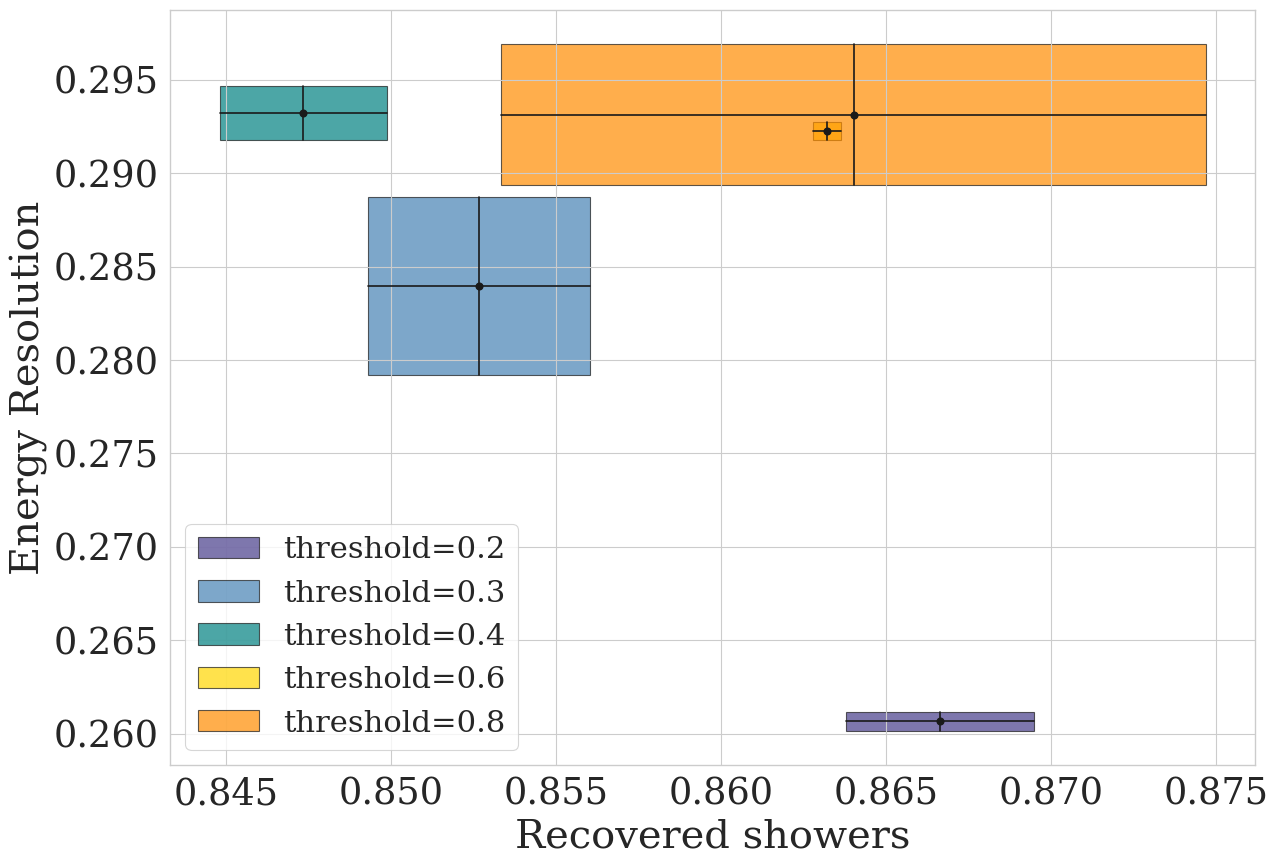

In [29]:
fig,(ax1) = plt.subplots(ncols=1, figsize=(14,10), dpi=100)
plt.title("")
for i, key in enumerate(keys[:]):
    x = np.array(GS_od[key])
    y = np.array(E_od[key])
    boxplot_2d(x,y, colors[i], ax=ax1, whis=1, label="threshold={}".format(key))
    

#plt.plot(GS_mean, E_mean)
plt.ylabel("Energy Resolution")
plt.xlabel("Recovered showers")
# plt.ylim
plt.legend(loc='best', fontsize=22)
plt.savefig("E_RS.pdf", bbox_inches='tight')
plt.show()